In [670]:
import pandas as pd
import numpy as np 
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [363]:
Data_to_add = pd.read_csv('../Datasets originales/Df_sold_homes_to_add.csv')

In [364]:
propertys_ids_to_add = Data_to_add['property_id'].to_list()

In [365]:
Houses_for_sale = pd.read_csv('../Dataset limpios/Houses_for_sale_processed.csv')

In [366]:
Data = pd.read_csv('../Dataset limpios/Houses_sold_processed.csv')

In [367]:
dicts = []
for id in propertys_ids_to_add:
    
    if id not in Data['property_id'].to_list():
        dict = Houses_for_sale[Houses_for_sale['property_id']==id].to_dict()
        dicts.append(dict)

In [368]:
print(f'''Hay un total de {len(propertys_ids_to_add)} ids para añadir al dataset de entrenamiento de los cuales \n
      {len(dicts)} no estaban ya en el dataset''')


Hay un total de 6662 ids para añadir al dataset de entrenamiento de los cuales 

      6650 no estaban ya en el dataset


In [369]:
dfs = []
for dict in dicts: 
    df = pd.DataFrame(dict)
    dfs.append(df)
Data_to_add = pd.concat(dfs,ignore_index=True)

In [370]:
Data_to_add.head(2)

,property_id,lon,lat,postal_code,state,city,state_code,line,fips_code,name,...,beds,type,primary_photo,tags,list_date,photos,list_price,listing_id,primary,status
0,1000163193,-122.340542,37.94899,94804,California,Richmond,CA,2814 Lowell Ave,6013.0,Contra Costa,...,2.0,single_family,{'href': 'https://ap.rdcpix.com/c40746b359c3d7...,"['central_air', 'community_outdoor_space', 'di...",2023-09-16,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,899000.0,2.959741e+09,True,for_sale
1,1000748625,-122.196956,47.91802,98208,Washington,Everett,WA,8729 Del Campo Dr,53061.0,Snohomish,...,4.0,single_family,{'href': 'https://ap.rdcpix.com/7501bd1b85a32e...,"['basement', 'community_outdoor_space', 'dinin...",2023-09-27,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,870000.0,2.960037e+09,True,for_sale


In [371]:
Data.head(2)

,property_id,lon,lat,postal_code,state,city,state_code,line,fips_code,name,...,stories,beds,type,primary_photo,tags,status,list_date,list_price,photos,listing_id
0,1000385902,-122.278787,37.877566,94703,California,Berkeley,CA,1532 McGee Ave,6001.0,Alameda,...,1.0,2.0,single_family,NaN,"['central_air', 'community_outdoor_space', 'de...",sold,2023-08-23,1125000.0,NaN,2.958976e+09
1,1000796714,-122.336493,37.942205,94804,California,Richmond,CA,3211 Clinton Ave,6013.0,Contra Costa,...,1.0,2.0,single_family,{'href': 'https://ap.rdcpix.com/64aed9a18d3926...,"['community_outdoor_space', 'dishwasher', 'fir...",sold,2023-08-24,599000.0,https://ap.rdcpix.com/64aed9a18d39263e131c5237...,2.958991e+09


In [372]:
Data_complete = pd.concat([Data,Data_to_add], ignore_index=True)

In [373]:
Data_complete.columns

Index(['property_id', 'lon', 'lat', 'postal_code', 'state', 'city',
       'state_code', 'line', 'fips_code', 'name', 'is_new_construction',
       'is_for_rent', 'is_contingent', 'is_price_reduced', 'is_foreclosure',
       'is_plan', 'is_coming_soon', 'street_view_url', 'year_built',
       'lot_sqft', 'sqft', 'baths', 'garage', 'stories', 'beds', 'type',
       'primary_photo', 'tags', 'status', 'list_date', 'list_price', 'photos',
       'listing_id', 'primary'],
      dtype='object')

In [374]:
Data_complete[Data_complete['is_new_construction'].notna()].shape

(118, 34)

It's worth nothing that out of all  the houses, only 118 have provided non-null values in that column. This is rather unusual, considerint that this column play a pivotal role in determining a house's pric. It's not a typical for sellers to leave this field empty by oversight. Therefore, for the time being, we'll assume that houses with null values in this column are casas where the calue should be interpreted as False

In [375]:
Data_complete['is_new_construction'] = Data_complete['is_new_construction'].fillna(False)

In [376]:
Data_complete['is_new_construction'] = Data_complete['is_new_construction'].apply(int)

In a similar vein, we will also interpret null values as False in similar columns

In [377]:
list_columns = [ 'is_for_rent', 'is_contingent', 'is_price_reduced', 'is_foreclosure']
for column in list_columns:
    Data_complete[column] = Data_complete[column].fillna(False)
    Data_complete[column] = Data_complete[column].apply(int)
    


This columns are somewhat subjetive, so i will drop them 

In [378]:
columns = ['is_plan', 'is_coming_soon']
Data_complete.drop(columns = columns, inplace=True)

In [379]:
columns = ['state_code', 'line','postal_code', 'state','name']
Data_complete.drop(columns = columns, inplace=True)

In [380]:
Data_complete.shape

(17746, 27)

In [381]:
columns = ['street_view_url', 'primary_photo','photos', 'listing_id']
Data_complete.drop(columns = columns, inplace=True)


In [382]:
Data_complete.columns

Index(['property_id', 'lon', 'lat', 'city', 'fips_code', 'is_new_construction',
       'is_for_rent', 'is_contingent', 'is_price_reduced', 'is_foreclosure',
       'year_built', 'lot_sqft', 'sqft', 'baths', 'garage', 'stories', 'beds',
       'type', 'tags', 'status', 'list_date', 'list_price', 'primary'],
      dtype='object')

In [383]:
Data_complete[Data_complete['year_built'].notna()].shape

(16856, 23)

In [384]:
Data_complete['year_built']

0        1914.0
1        1942.0
2        1919.0
3        1999.0
4        1977.0
          ...  
17741    2021.0
17742    2021.0
17743    2023.0
17744    2020.0
17745    1920.0
Name: year_built, Length: 17746, dtype: float64

In [385]:
def year():#return current year
    
    current_time = time.time()

    time_structure = time.localtime(current_time)

    
    current_year = time_structure.tm_year

    return current_year

In [386]:
def get_age(year_text):

    current_year = year()

    return current_year - year_text 

In [387]:
Data_complete['year_built'] = Data_complete['year_built'].apply(get_age)


In [388]:
city_mean_age = Data_complete.groupby('city')['year_built'].mean().round(2).reset_index()
city_mean_age.to_csv('City_age.csv',index=False)

In [389]:
def mean_city_age(df):
    df = df.copy()
    for index, row in df.iterrows():

        if pd.isna(row['year_built']):

            mean_city = city_mean_age[city_mean_age['city']==row['city']]['year_built'].iloc[0]
            df.at[index, 'year_built']= mean_city
        
    return df

In [390]:
Data_complete = mean_city_age(Data_complete)

In [391]:
Data_complete[Data_complete['year_built'].isna()]

,property_id,lon,lat,city,fips_code,is_new_construction,is_for_rent,is_contingent,is_price_reduced,is_foreclosure,...,baths,garage,stories,beds,type,tags,status,list_date,list_price,primary
5201,4569238730,-81.546412,40.930327,New Franklin,39153.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,"['no_hoa', 'lake']",sold,2023-08-15,39500.0,NaN
7019,6733312820,-76.440055,39.290685,Essex,24005.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,"['corner_lot', 'big_lot', 'farm']",sold,2023-03-30,59900.0,NaN
7225,6964244179,-80.599973,35.188303,Mint Hill,37119.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,['big_lot'],sold,2023-04-15,649900.0,NaN
8992,8225628614,-96.887587,32.739279,Cockrell Hill,48113.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,"['no_hoa', 'park']",sold,2023-09-13,125000.0,NaN
10346,9252938749,-98.269276,26.283457,Mission,48215.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,NaN,sold,NaN,NaN,NaN
10508,9396017540,-97.617568,30.385877,Manor,48453.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,NaN,sold,NaN,NaN,NaN
10577,9468965631,-83.269207,33.873717,Winterville,13059.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,['big_lot'],sold,2023-03-20,479961.0,NaN
10860,9764425021,-86.706944,33.623087,Center Point,1073.0,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,"['wooded_land', 'rental_property']",sold,2023-03-29,18000.0,NaN
10954,9862746158,NaN,NaN,Boone,NaN,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,"['hill_or_mountain_view', 'view', 'big_lot', '...",sold,2023-03-09,135000.0,NaN
10993,9901356445,NaN,NaN,Dexter City,NaN,0,0,0,0,0,...,0.0,NaN,NaN,NaN,land,NaN,sold,2023-05-02,70300.0,NaN


In [392]:
city_mean_age[city_mean_age['city']=='New Franklin']

,city,year_built
324,New Franklin,NaN


In [393]:
Data_complete['year_built'] = Data_complete['year_built'].fillna(Data_complete['year_built'].mean())

In [394]:
Data_complete[Data_complete['year_built'].isna()]

,property_id,lon,lat,city,fips_code,is_new_construction,is_for_rent,is_contingent,is_price_reduced,is_foreclosure,...,baths,garage,stories,beds,type,tags,status,list_date,list_price,primary


In [395]:
Data_complete.columns

Index(['property_id', 'lon', 'lat', 'city', 'fips_code', 'is_new_construction',
       'is_for_rent', 'is_contingent', 'is_price_reduced', 'is_foreclosure',
       'year_built', 'lot_sqft', 'sqft', 'baths', 'garage', 'stories', 'beds',
       'type', 'tags', 'status', 'list_date', 'list_price', 'primary'],
      dtype='object')

In [396]:
Data_complete[Data_complete['lot_sqft'].isna()].shape

(2196, 23)

In [397]:
Data_complete['diff lot_sqft-sqft'] = Data_complete['lot_sqft'] - Data_complete['sqft'] 

In [398]:
city_mean_lot_sqft_sqft = Data_complete.groupby('city')['diff lot_sqft-sqft'].mean().round(2).reset_index()

In [399]:
city_mean_lot_sqft_sqft

,city,diff lot_sqft-sqft
0,Abilene,16972.30
1,Agassiz,1026.00
2,Agua Dulce,192612.00
3,Airport Hill,21691.00
4,Akron,6928.74
...,...,...
532,Worthington,4508.50
533,Wyoming,4804.50
534,Yonkers,3681.35
535,York,37284.67


In [400]:
def mean_city_lot(df):
    df = df.copy()
    for index, row in df.iterrows():

        if pd.isna(row['lot_sqft']):

            mean_city = city_mean_lot_sqft_sqft[city_mean_lot_sqft_sqft['city']==row['city']]['diff lot_sqft-sqft'].iloc[0]

            df.at[index, 'lot_sqft']= mean_city + row['sqft']
        
    return df

In [401]:
Data_complete = mean_city_lot(Data_complete)

In [402]:
Data_complete[Data_complete['lot_sqft'].isna()].shape

(142, 24)

In [403]:
Data_complete['lot_sqft'] = Data_complete['lot_sqft'].fillna(Data_complete['lot_sqft'].mean())

In [404]:
def mean_city_sqft(df):
    df = df.copy()
    for index, row in df.iterrows():

        if pd.isna(row['sqft']):

            mean_city = city_mean_lot_sqft_sqft[city_mean_lot_sqft_sqft['city']==row['city']]['diff lot_sqft-sqft'].iloc[0]

            df.at[index, 'sqft'] = row['lot_sqft'] - mean_city
        
    return df

In [405]:
Data_complete = mean_city_sqft(Data_complete)


In [406]:
Data_complete[Data_complete['sqft'].isna()].shape

(31, 24)

In [407]:
Data_complete[Data_complete['sqft'].isna()].head()

,property_id,lon,lat,city,fips_code,is_new_construction,is_for_rent,is_contingent,is_price_reduced,is_foreclosure,...,garage,stories,beds,type,tags,status,list_date,list_price,primary,diff lot_sqft-sqft
5201,4569238730,-81.546412,40.930327,New Franklin,39153.0,0,0,0,0,0,...,NaN,NaN,NaN,land,"['no_hoa', 'lake']",sold,2023-08-15,39500.0,NaN,NaN
5668,5172996886,-74.226876,40.751189,City of Orange Township,34013.0,0,0,0,0,0,...,NaN,NaN,4.0,single_family,"['community_outdoor_space', 'forced_air', 'har...",sold,2023-06-06,300000.0,NaN,NaN
5920,5485255954,-74.210129,40.676601,Elizabeth,34039.0,0,0,0,0,0,...,1.0,2.0,4.0,single_family,"['central_air', 'community_outdoor_space', 'di...",sold,2023-07-15,499000.0,NaN,NaN
5995,5564756866,-79.952070,36.025146,Jamestown,37081.0,0,0,0,0,0,...,2.0,2.0,4.0,single_family,"['central_air', 'community_outdoor_space', 'co...",sold,2023-08-21,379000.0,NaN,NaN
6239,5836866816,-79.955290,35.923353,Archdale,37081.0,0,0,0,0,0,...,2.0,2.0,3.0,single_family,"['central_air', 'community_outdoor_space', 'cu...",sold,2023-08-10,250000.0,NaN,NaN


In [408]:
Data_complete['sqft'] = Data_complete['sqft'].fillna(Data_complete['sqft'].mean())


For these columns,['baths', 'garage', 'stories', 'beds'] null values will be assumed to be houses with the minimum value, which in this case is 1, as if they were the average value for a house.

In [409]:
Data_complete[['baths', 'garage', 'stories', 'beds']] = Data_complete[['baths', 'garage', 'stories', 'beds']].fillna(1)

In [410]:
Data_complete.type

0        single_family
1        single_family
2        single_family
3        single_family
4        single_family
             ...      
17741    single_family
17742    single_family
17743    single_family
17744     multi_family
17745    single_family
Name: type, Length: 17746, dtype: object

In [411]:
Data_complete['type'].value_counts()


type
single_family                  12635
condos                          2090
townhomes                       1140
multi_family                     869
land                             429
mobile                           265
condo                            200
other                             72
duplex_triplex                    17
condo_townhome_rowhome_coop       12
farm                               3
apartment                          2
coop                               1
Name: count, dtype: int64

In [412]:
Data_complete['type'] = Data_complete['type'].fillna('single_family')


In [413]:
Data_complete.columns

Index(['property_id', 'lon', 'lat', 'city', 'fips_code', 'is_new_construction',
       'is_for_rent', 'is_contingent', 'is_price_reduced', 'is_foreclosure',
       'year_built', 'lot_sqft', 'sqft', 'baths', 'garage', 'stories', 'beds',
       'type', 'tags', 'status', 'list_date', 'list_price', 'primary',
       'diff lot_sqft-sqft'],
      dtype='object')

In [414]:
Data_complete.drop(columns='status',inplace = True)

In [415]:
Data_complete[Data_complete['list_price'].isna()].shape

(1840, 23)

In [416]:
Data_complete.dropna(subset='list_price', inplace=True)

In [417]:
Data_complete.drop('primary', axis=1,inplace = True)

In [418]:
Data_complete

,property_id,lon,lat,city,fips_code,is_new_construction,is_for_rent,is_contingent,is_price_reduced,is_foreclosure,...,sqft,baths,garage,stories,beds,type,tags,list_date,list_price,diff lot_sqft-sqft
0,1000385902,-122.278787,37.877566,Berkeley,6001.0,0,0,0,0,0,...,1149.0,1.0,1.0,1.0,2.0,single_family,"['central_air', 'community_outdoor_space', 'de...",2023-08-23,1125000.0,2331.0
1,1000796714,-122.336493,37.942205,Richmond,6013.0,0,0,0,0,0,...,1084.0,2.0,2.0,1.0,2.0,single_family,"['community_outdoor_space', 'dishwasher', 'fir...",2023-08-24,599000.0,3916.0
2,1001913806,-122.280329,37.877482,Berkeley,6001.0,0,0,0,0,0,...,920.0,1.0,1.0,2.0,2.0,single_family,"['corner_lot', 'dining_room', 'dishwasher', 'f...",2023-08-18,849000.0,1978.0
3,1001994147,-119.161436,35.358035,Bakersfield,6029.0,0,0,0,0,0,...,2181.0,3.0,3.0,1.0,3.0,single_family,"['central_air', 'central_heat', 'community_out...",2023-08-18,493999.0,7402.0
4,1002195150,-121.825823,38.002719,Antioch,6013.0,0,0,0,0,0,...,1154.0,2.0,2.0,1.0,3.0,single_family,"['central_air', 'dishwasher', 'forced_air', 'l...",2023-08-18,400000.0,2246.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17741,9980537142,-97.070558,32.533213,Grand Prairie,48139.0,0,0,0,0,0,...,1997.0,2.0,3.0,1.0,4.0,single_family,"['central_air', 'central_heat', 'community_clu...",2023-09-28,460000.0,5800.0
17742,9983156711,-87.298900,36.489861,Clarksville,47125.0,0,0,0,0,0,...,3053.0,2.5,2.0,2.0,4.0,single_family,"['community_outdoor_space', 'fireplace', 'two_...",2023-09-26,569900.0,14371.0
17743,9986200218,-123.082390,44.970707,Salem,41053.0,1,0,0,0,0,...,2497.0,2.5,2.0,1.0,3.0,single_family,"['central_heat', 'community_outdoor_space', 'f...",2023-09-26,649900.0,5344.0
17744,9987436633,-104.936834,39.728226,Denver,8031.0,0,0,0,0,0,...,3194.0,4.5,2.0,3.0,3.0,multi_family,"['central_air', 'community_outdoor_space', 'di...",2023-09-28,1700000.0,-48.0


In [419]:
label_encoder = LabelEncoder()

In [420]:
Data_complete['encoded_city'] = label_encoder.fit_transform(Data_complete['city'])
Data_complete.drop(columns='city', inplace = True)

In [421]:
Data_complete['encoded_type'] = label_encoder.fit_transform(Data_complete['type'])
Data_complete.drop(columns='type', inplace = True)

In [423]:
Data_complete[['encoded_city','encoded_type']]

,encoded_city,encoded_type
0,33,9
1,396,9
2,33,9
3,26,9
4,15,9
...,...,...
17741,174,9
17742,81,9
17743,409,9
17744,111,8


In [424]:
#poner en lista cada una de las filas de la columna tags
def get_tags(list):
    
    my_list = []
    try:
        for tag in eval(list):
            my_list.append(tag)
        return my_list 
    except:
        return my_list

In [425]:
#Aplicar la funciona a cada fila de la columna tags
tags = []
#recorre cada fila del datafram para sacar los tags
for index, row in Data_complete.iterrows():
    
    tag=get_tags(row['tags'])

    tags+=tag

In [426]:
#para eliminar las tags que son las mas frecuentes 
Start_tags=0
current_tags=1
while Start_tags != current_tags:
    Start_tags=len(tags)
    for tag in tags:
        #eliminar las palabras garage y story pues ya son parte del dataframe
        if 'garage' in tag or 'story' in tag or 'stories' in tag:
            tags.remove(tag)
    current_tags=len(tags)

In [427]:
tags[0]

'central_air'

In [428]:
#definir los tags unicos que hay en tags
tags_unicos ={}
#recorrer los tags para sacar un diccionario con los nombres y cantidad de tags
for tag in tags:
    if tag not in tags_unicos.keys():
        tags_unicos[tag]=tags.count(tag)
    else:
        tags.remove(tag)

#poner el resultado del diccionario en un dataframe
top_50_tags = pd.DataFrame(tags_unicos.values(),tags_unicos.keys()).sort_values(by=0,ascending=False).head(50).rename(columns={0:'count'})
top_50_tags.head(3)

,count
central_air,9901
laundry_room,8967
community_outdoor_space,8030


In [429]:
top_50_tags = top_50_tags.reset_index().rename(columns={'index':'tag'})

In [430]:
# Define a reference list of values to compare against
my_ref_list = top_50_tags['tag'].to_list()

# Iterate through each column
for column in Data_complete[['tags']]:
    # Initialize a dictionary to store One-Hot Encoding results
    encoding_dict = {}
    
    # Iterate through each value in the column's list
    for value in my_ref_list:
        # Check if the value is in the list
        encoding_dict[f'{value}'] = [int(isinstance(lst, list) and value in lst) for lst in Data_complete[column]]
    
    # Create a new DataFrame from the encoding_dict
    encoding_df = pd.DataFrame(encoding_dict)
    
    

In [431]:
Data_complete = Data_complete.reset_index().drop(columns='index')

In [432]:
# Concatenate the dataframes side by side
result = pd.concat([Data_complete, encoding_df], axis=1)

In [433]:
result.drop(columns='tags', inplace=True)

In [434]:
result.set_index('property_id',inplace=True)

In [435]:
result

,lon,lat,fips_code,is_new_construction,is_for_rent,is_contingent,is_price_reduced,is_foreclosure,year_built,lot_sqft,...,views,master_bedroom,water_view,vaulted_ceiling,ranch,trails,cul_de_sac,clubhouse,tennis_court,master_suite
property_id,,,,,,,,,,,,,,,,,,,,,
1000385902,-122.278787,37.877566,6001.0,0,0,0,0,0,109.0,3480.0,...,0,0,0,0,0,0,0,0,0,0
1000796714,-122.336493,37.942205,6013.0,0,0,0,0,0,81.0,5000.0,...,0,0,0,0,0,0,0,0,0,0
1001913806,-122.280329,37.877482,6001.0,0,0,0,0,0,104.0,2898.0,...,0,0,0,0,0,0,0,0,0,0
1001994147,-119.161436,35.358035,6029.0,0,0,0,0,0,24.0,9583.0,...,0,0,0,0,0,0,0,0,0,0
1002195150,-121.825823,38.002719,6013.0,0,0,0,0,0,46.0,3400.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980537142,-97.070558,32.533213,48139.0,0,0,0,0,0,2.0,7797.0,...,0,0,0,0,0,0,0,0,0,0
9983156711,-87.298900,36.489861,47125.0,0,0,0,0,0,2.0,17424.0,...,0,0,0,0,0,0,0,0,0,0
9986200218,-123.082390,44.970707,41053.0,1,0,0,0,0,0.0,7841.0,...,0,0,0,0,0,0,0,0,0,0


In [436]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15906 entries, 1000385902 to 9993679106
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   lon                          15766 non-null  float64
 1   lat                          15766 non-null  float64
 2   fips_code                    15288 non-null  float64
 3   is_new_construction          15906 non-null  int64  
 4   is_for_rent                  15906 non-null  int64  
 5   is_contingent                15906 non-null  int64  
 6   is_price_reduced             15906 non-null  int64  
 7   is_foreclosure               15906 non-null  int64  
 8   year_built                   15906 non-null  float64
 9   lot_sqft                     15906 non-null  float64
 10  sqft                         15906 non-null  float64
 11  baths                        15906 non-null  float64
 12  garage                       15906 non-null  float64
 13  stories

In [441]:
result.dropna(subset='lon', inplace=True)
result.dropna(subset='fips_code', inplace=True)

In [439]:
result.drop(columns='list_date', inplace = True)

In [700]:
result.drop(columns='diff lot_sqft-sqft', inplace = True)

In [442]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15288 entries, 1000385902 to 9993679106
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   lon                          15288 non-null  float64
 1   lat                          15288 non-null  float64
 2   fips_code                    15288 non-null  float64
 3   is_new_construction          15288 non-null  int64  
 4   is_for_rent                  15288 non-null  int64  
 5   is_contingent                15288 non-null  int64  
 6   is_price_reduced             15288 non-null  int64  
 7   is_foreclosure               15288 non-null  int64  
 8   year_built                   15288 non-null  float64
 9   lot_sqft                     15288 non-null  float64
 10  sqft                         15288 non-null  float64
 11  baths                        15288 non-null  float64
 12  garage                       15288 non-null  float64
 13  stories

<Axes: xlabel='property_id'>

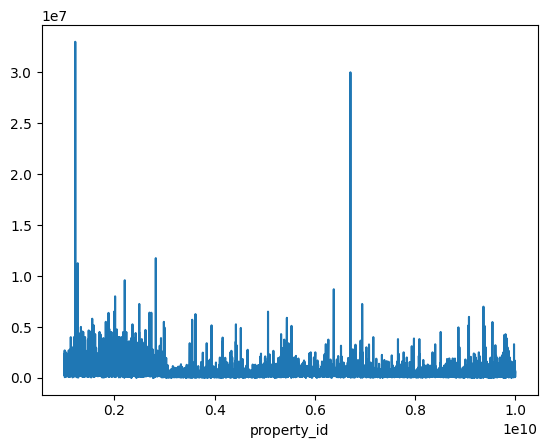

In [444]:
result['list_price'].plot()

In [527]:
price = pd.DataFrame()

In [542]:
result[['list_price']].reset_index().sort_values(by='property_id').reset_index().drop(columns='index').set_index('property_id')

,list_price
property_id,
1000163193,899000.0
1000385902,1125000.0
1000748625,870000.0
1000796714,599000.0
1001237574,1899000.0
...,...
9996599451,599000.0
9996753301,65000.0
9997392724,345000.0


In [594]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [633]:
price = result[['list_price']].reset_index().sort_values(by='property_id').reset_index().drop(columns='index').set_index('property_id')

In [634]:
price_array = price['list_price'].to_numpy()

In [635]:
# Define your threshold value
threshold = 1e7 # Replace with your desired threshold

# Create a boolean mask for values below the threshold
mask = price_array <= threshold

# Filter the array to keep only values below the threshold
filtered_price_array = price_array[mask]

In [636]:
filtered_price_array

array([ 899000., 1125000.,  870000., ...,  345000.,  700000.,   99700.])

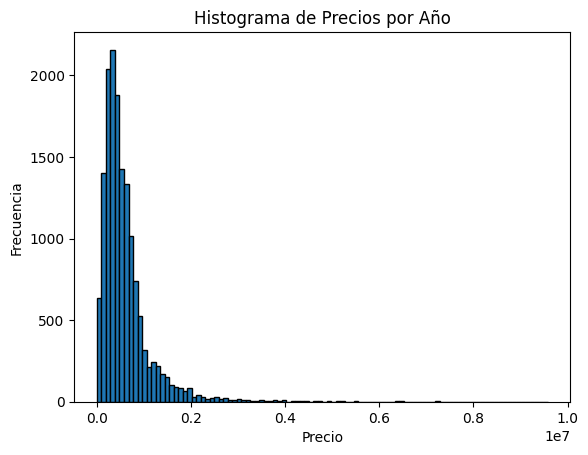

In [637]:
plt.hist(filtered_price_array, bins=100, edgecolor='black')  
plt.title('Histograma de Precios por Año')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

In [638]:
price['list_price']

property_id
1000163193     899000.0
1000385902    1125000.0
1000748625     870000.0
1000796714     599000.0
1001237574    1899000.0
                ...    
9996599451     599000.0
9996753301      65000.0
9997392724     345000.0
9998824963     700000.0
9999189314      99700.0
Name: list_price, Length: 15288, dtype: float64

In [648]:
# Define a window size
window_size = 100

# Set the sigma value, which is 3, although a slightly larger value could be chosen due to data dispersion
sigma = 8

# Define the  ceiling of the graph
price['ceiling'] = price['list_price'].rolling(window=window_size).mean() + (sigma * price['list_price'].rolling(window=window_size).std())

<Axes: xlabel='property_id'>

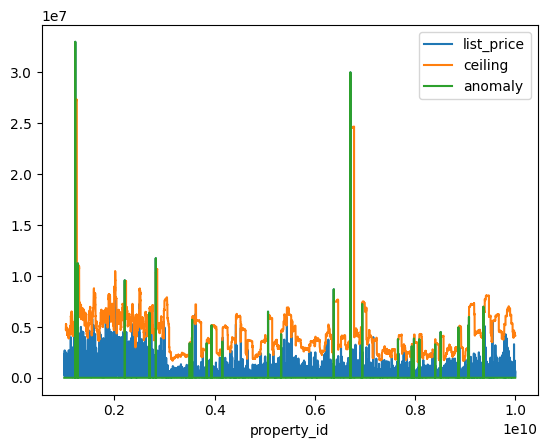

In [649]:
price.plot()

<Axes: xlabel='property_id'>

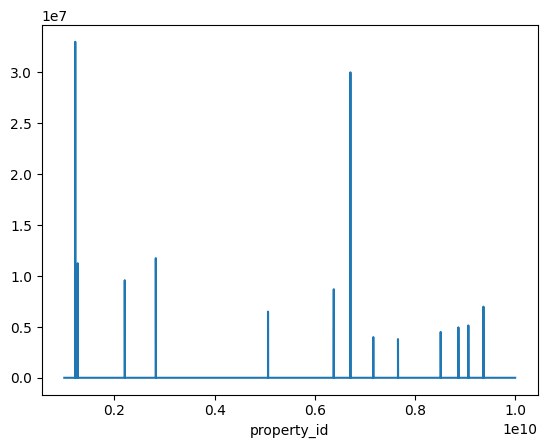

In [650]:
price['anomaly']=price.apply(
    lambda row: row['list_price'] if (row['list_price']>=row['ceiling']) else 0, axis=1
)
price['anomaly'].plot()

In [651]:
price[price['anomaly']!=0]

,list_price,ceiling,anomaly
property_id,,,
1219585460,33000000.0,2.734582e+07,33000000.0
1268210483,11250000.0,1.076620e+07,11250000.0
2207162835,9580000.0,9.091289e+06,9580000.0
2826711544,11750000.0,1.017990e+07,11750000.0
5066580275,6495000.0,6.238276e+06,6495000.0
6378956752,8695000.0,7.505443e+06,8695000.0
6711130841,29999999.0,2.458093e+07,29999999.0
7167802095,3995000.0,3.711099e+06,3995000.0
7660300475,3800000.0,3.726686e+06,3800000.0


In [652]:
anomalous_ids = price[price['anomaly']!=0].reset_index()['property_id'].to_list()

In [655]:
result.drop(anomalous_ids, inplace=True)

In [701]:
x = result.drop(columns='list_price')
y = result['list_price']

In [702]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [703]:
x_train.shape, x_test.shape

((12220, 67), (3055, 67))

In [704]:
model = XGBRegressor()

In [705]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

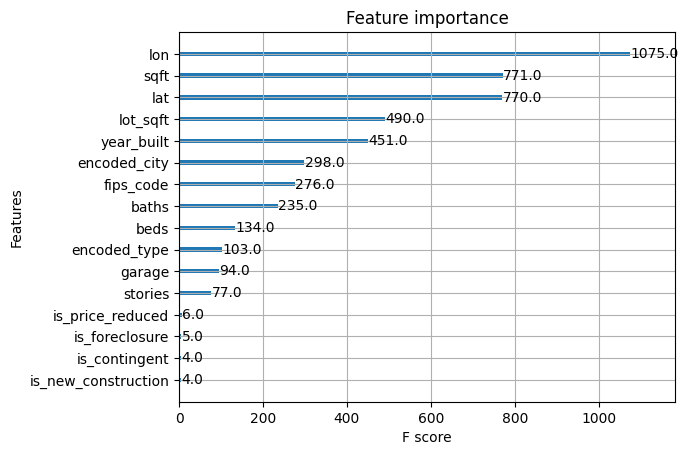

In [707]:
xgb.plot_importance(model)